# South African Language Identification Hack 2022

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of determining the natural language that a piece of text is written in

We're going to take the followeing approach:
1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

## 1. Problem Definition

In a statement,
> Given South Africa's 11 Official languages, can we determine the natural language that a piece of text is written in?

## Data

The dataset used for this challenge is the NCHLT Text Corpora collected by the South African Department of Arts and Culture & Centre for Text Technology (CTexT, North-West University, South Africa). The training set was improved through additional cleaning done by Praekelt.

There is also a version of it available on kaggle. https://www.kaggle.com/competitions/south-african-language-identification-hack-2022/data

## 3. Evaluation

> If we can reach 90% accuracy at determining the natural language that a piece of text is written in, we'll pursue the project.

## 4. Features

* Language IDs:

    * afr - Afrikaans

    * eng - English

    * nbl - isiNdebele

    * nso - Sepedi

    * sot - Sesotho

    * ssw - siSwati

    * tsn - Setswana

    * tso - Xitsonga

    * ven - Tshivenda

    * xho - isiXhosa

    * zul - isiZulu

### The files provided

* train.csv - The training set.

* test.csv - The test set.

* SampleSubmission.csv - a sample submission file in the correct format.

<a id="cont"></a>
### Table of Contents

<a href=#one>1.  Preparing the tools </a>

<a href=#two>2.  Feature Engineering </a>

<a href=#three>3.  Setting up the train_test_split </a>

<a href=#four>4.  Training The Model </a>

<a href=#five>5.   Score Model </a>

<a href=#six>6.  Hypperparameter tuning </a>

<a href=#seven>7.  Hyperparameter tuning with RandomizedSearchCV </a>

<a href=#eight>8.  Hyperparameter tuning with GridSearchCV </a>

<a href=#nine>9.  RandomizedSearchCV VS GridSearchCV </a>

<!-- <a href=#ten>10. Hypperparameter tuning </a> -->

<!-- <a href=#eleven>11. Conclusion </a>

<a href=#twelve>12. References  </a> -->

<a id="one"></a>
## Preparing the tools
We're going to use pandas, Matplotlib, NumPy and Scklearn for data analysis and manipulation

<a href=#cont>Back to Table of Contents</a>

In [158]:
# Libraries for data loading and data visulisation
import re
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

# Libraries for modelling
#Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

#Thi library is useful for resampling our data
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

#Model Evaluations
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve


In [159]:
# Load training dataset
df_train = pd.read_csv("train_set.csv")

In [160]:
# View first five rows of the train_dataset
df_train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [161]:
#Check for Number of rows and column
df_train.shape

(33000, 2)

In [162]:
#Check for unique language id
df_train.lang_id.unique()

array(['xho', 'eng', 'nso', 'ven', 'tsn', 'nbl', 'zul', 'ssw', 'tso',
       'sot', 'afr'], dtype=object)

In [163]:
#Get more informatioin of the various data types contained in the dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


In [164]:
# Check for missing values in the dataset
df_train.isnull().sum()

lang_id    0
text       0
dtype: int64

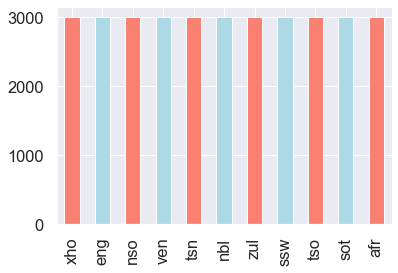

In [165]:
#Plot for the lang_id classifications
df_train["lang_id"].value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

**Observations:**
- The dataset has 33,000 rows and 2 columns
- The dataset contains 11 unique language Id
- The datatypes of the columns are objects, they have to be vectorized in order to fit properly to our machine learning model
- There are no missing values in the data set
- The categories of the language id are all balanced as indicated in the bar plot above

<a id="two"></a>
## DATA / FEATURE ENGINEERING

<a href=#cont>Back to Table of Contents</a>

### To get an idea of the word that appears the most, we use the wordcloud library

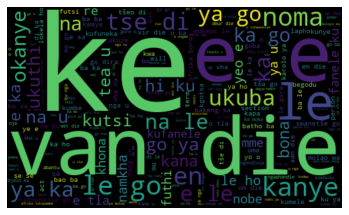

In [166]:
from wordcloud import WordCloud #Import the library for displaying an image of the most usd words
#Loop through all the word in the new_message column and get the number of time they each appear, store the answer in a variable
allwords = ''.join( [msgs for msgs in df_train['text']])
#Set the heigh and with of the image, random-state=42 makes our code to be repeated on other machines and get the same result
# Set the maximum font size as 199 
wordCloud = WordCloud(width=500, height=300, random_state=42, max_font_size=199).generate(allwords)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

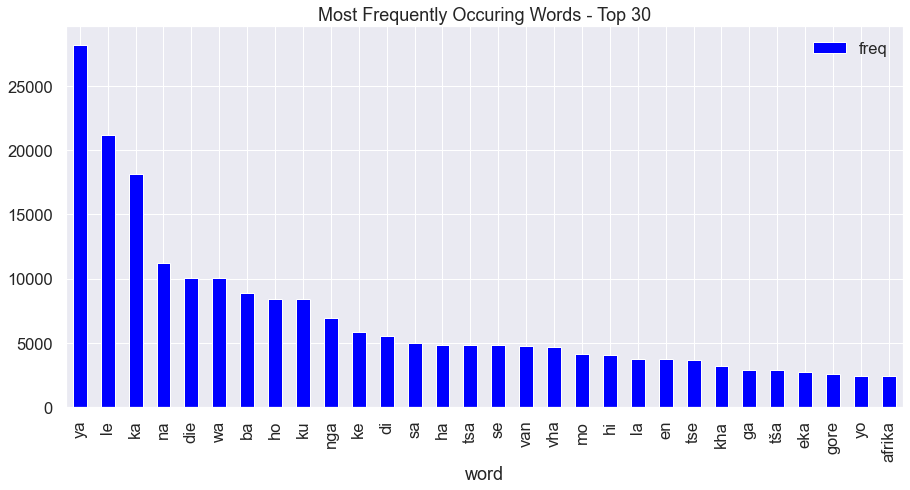

In [167]:
from sklearn.feature_extraction.text import CountVectorizer # Import the vectorizer library


cv = CountVectorizer(stop_words = 'english') #Vectorize stop words and store in a variable cv
words = cv.fit_transform(df_train.text) #fit the "new_message" column into cv and store in a variable words

sum_words = words.sum(axis=0) #sum all the words in the rows

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()] #loop through the all the words in new_message and compute them
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)# note the frequency of occuence of each words

frequency = pd.DataFrame(words_freq, columns=['word', 'freq']) #plot a chart of the frequency of occurence

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue') #apply settings to the chart
plt.title("Most Frequently Occuring Words - Top 30")#Only plot the 30 most used woords

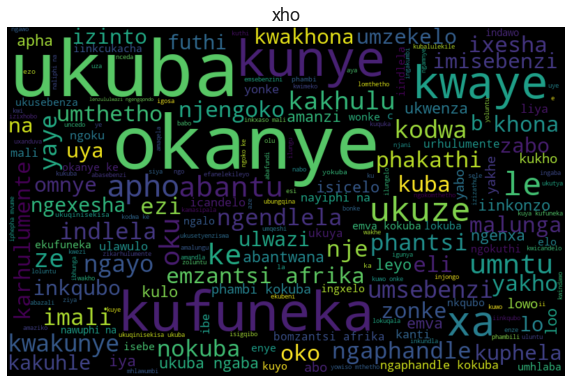

In [168]:
#Word count for xho languange_id
normal_words =' '.join([text for text in df_train['text'][df_train['lang_id'] == 'xho']])

wordcloud = WordCloud(width=800, height=500, random_state = 42, max_font_size = 110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('xho')
plt.show()

In [169]:
df_train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


**Note**:
    since the words are in Afrikaans, we dont need to remove stopwords, apply lemmatizerr nor stemming

### Transforming text into numbers

#### 1. Features

Before we can feed our data into our machine learning model, we need to first transform the text into vector numbers. The idea is to get some distinct features out of the text for the model to train on, by converting text to numerical vectors: https://neptune.ai/blog/vectorization-techniques-in-nlp-guide#:~:text=In%20Machine%20Learning%2C%20vectorization%20is,converting%20text%20to%20numerical%20vectors. 
We can apply this method using Sklearn as follows:

In [170]:
# Let's use the count vectorizer with its default hyperparameters
vect = CountVectorizer() #store the library to converttext to numbers into a variable
X_count = vect.fit_transform(df_train['text'].values.astype(str))#apply the transformation to the specified column

In [171]:
X_count.shape

(33000, 141958)

In [178]:
%%time
vect_5 = CountVectorizer(lowercase=True, stop_words='english', max_features=100,analyzer='word', ngram_range=(1, 3))
X_count = vect_5.fit_transform(df_train['text'].values.astype(str))

CPU times: total: 18.5 s
Wall time: 19.7 s


In [179]:
X_count.shape

(33000, 100)

In [180]:
X = X_count.toarray()

In [181]:
#Standarise the data
standard_scaler = StandardScaler()
X_transformed = standard_scaler.fit_transform(X)

In [182]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# Fit label encoder and return encoded labels
y = le.fit_transform(df_train['lang_id'])
classes=le.classes_

LabelEncoder encode labels with a value between 0 and n_classes-1 where n is the number of distinct labels.

In [183]:
y

array([9, 9, 1, ..., 1, 9, 4])

<a id="three"></a>
## Setting up the train_test_split
<a href=#cont>Back to Table of Contents</a>

In [184]:
#Split data to train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<a id="four"></a>
## Training The Model 
Now we have our data split into training and test sets, its time to build a machine learning model. 
We'll train it (find the patterns) on the training set
And we'll test it (use the patterns) on the test set

We're going to try 7 different machine learning models for now:

1. Logistic regression
2. K-Nearest Neighbours Classifiers
3. Randoom Forest Classifier
4. AdaBoost Classifier
5. Lagrangian Support Vector Machine (LSVM)
6. Radial Basis Function
7. Decision Tree

#### Note:
- After smpling various, I decided to go with the best 3 to maximise processing time

<a href=#cont>Back to Table of Contents</a>

In [185]:
# Put modelsin a dictionary
models = {"Logistic Regression": LogisticRegression(),
          "Decision Tree": DecisionTreeClassifier(max_depth=5),
          "LSVM": SVC(kernel="linear", C=0.025)}
        #"Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
          #"AdaBoost":AdaBoostClassifier(),
        #"KNN": KNeighborsClassifier(3),
         #"RBF SVM": SVC(gamma=2, C=1),
         #"Decision Tree": DecisionTreeClassifier(max_depth=5)}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dictionary of different Scikit-Learn machine learning models
    x_train : training data (no labels)
    x_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    # name is the key and model is the value of our dictionry
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores
        

<a id="five"></a>
## Score Model
<a href=#cont>Back to Table of Contents</a>

In [186]:
%%time
# Lets evaluate our models and see how they performed
import time

model_scores = fit_and_score(models=models,
                            X_train=X_train,
                            X_test=X_test,
                            y_train=y_train,
                            y_test=y_test)
model_scores

CPU times: total: 46.2 s
Wall time: 43.8 s


{'Logistic Regression': 0.8486363636363636,
 'Decision Tree': 0.5318181818181819,
 'LSVM': 0.8366666666666667}

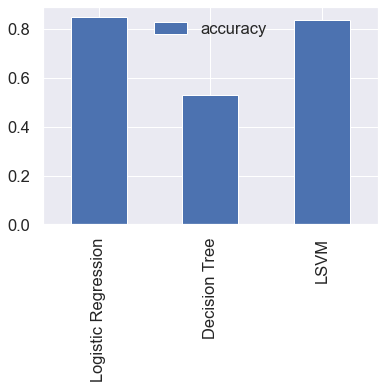

In [187]:
model_comapre = pd.DataFrame(model_scores, index=["accuracy"])
model_comapre.T.plot.bar();

From the initial test, the **Logistic regression** model seem to perform better, hence we will perform our hyperparameter tunning on **Logistic Regression**

<a id="six"></a>
## Hypperparameter tuning

Now we've got a baseline model.... we know a model's first
predictions aren't always what we should based our next steps off.
what should we do?

Let's look at the following:
* Hyperparameter tuning
* Feature importance
* Confussion matrix
* Precision
* Recall
* F1 Score
* Classification report
* ROC Curve
* Area under the curve (AUC)

<a href=#cont>Back to Table of Contents</a>

<a id="seven"></a>
## Hyperparameter tuning with RandomizedSearchCV
We're going to tune:
    * LogisticRegression()
    * RandomForestClassifier()
... Using RandomizedSearchCV

<a href=#cont>Back to Table of Contents</a>

In [188]:
# Create a hyperparameters for LogisticRegression
log_reg_grid = {"C": np.logspace(-4, 4, 20),
               "solver": ["liblinear"]}
               #"penalty": ["l2"]}

#### Note
- C is regularization strength, it works with penality to lower overfitting
- `logspace':` This return numbers spaced evenly on a log scale.
    - **-4:** Start is the starting value of the sequence.
    - **4:** Stop is the final value of the sequence, unless endpoint is False
    - **20:** Number of samples to generate

In [189]:
%%time
#Tune LogisticRegression

np.random.seed(42)

# Setup random hyprparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                               param_distributions=log_reg_grid,
                               cv=5,
                               n_iter=10,
                               verbose=True)

# Fit random hyperparameter search model for LogisticRegression
rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: total: 2min 35s
Wall time: 2min 32s


RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

#### Note
- Fit our LogisticRegression model on our RandomizedSearchCV
- Load our parameters distribution into the RandomizedSearchCV
- set our `Cross-Validation (cv)` to **5** meaning our model will be tested 5 times By dividing the data into 5 parts, choosing one part as testing and the other four as training data.
- `n_iter=10` means the model will be fit 10 times for different combination of parameter distributions specified

In [190]:
# To check the best parmeters obtained by the hyperparameter test
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 3792.690190732246}

**C= 4.281332398719396 is an indication that of strong regularization, high value tells the model to give high weight to the training data.** 

In [191]:
#Compare the new test score with the old one, an improvement of 0.0009090909090909 was achieved with the RandomizedSearchCV
rs_log_reg.score(X_test, y_test), model_scores

(0.8495454545454545,
 {'Logistic Regression': 0.8486363636363636,
  'Decision Tree': 0.5318181818181819,
  'LSVM': 0.8366666666666667})

#### Logistic Regression Hyperparameters

The main hyperparameters we may tune in logistic regression are: solver, penalty, and regularization strength (sklearn documentation).

**Solver** is the algorithm to use in the optimization problem. The choices are {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’.

- 1. `lbfgs` relatively performs well compared to other methods and it saves a lot of memory, however, sometimes it may have issues with convergence.
- 2. `sag` faster than other solvers for large datasets, when both the number of samples and the number of features are large.
- 3. `saga` the solver of choice for sparse multinomial logistic regression and it’s also suitable for very large datasets.
- 4. `newton-cg` computationally expensive because of the Hessian Matrix.
- 5. `liblinear` recommended when you have a high dimension dataset - solving large-scale classification problems.

**Penalty (or regularization)** intends to reduce model generalization error, and is meant to disincentivize and regulate overfitting. Technique discourages learning a more complex model, so as to avoid the risk of overfitting. The choices are: `{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’`. However, some penalties may not work with some solvers, the following table summarizes the penalties supported by each solver:

**C (or regularization strength)** must be a positive float. Regularization strength works with the penalty to regulate overfitting. Smaller values specify stronger regularization and high value tells the model to give high weight to the training data.

https://miro.medium.com/max/1400/1*FWJGq3mDDZJxTVWkdmMAjA.webp

**Reference:** https://medium.com/codex/do-i-need-to-tune-logistic-regression-hyperparameters-1cb2b81fca69
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

<a id="eight"></a>
## Hyperparameter tuning with GridSearchCV

Since our LogisticRegression model provides he best scores so far, we'll try and improve them again using GridSearchCV

<a href=#cont>Back to Table of Contents</a>

In [192]:
%%time
# Different hyperparameters for our LogisticRegression model
log_reg_grid = {"C": np.logspace(-4, 4, 8),
               "solver": ["lbfgs"],
               "penalty": ["l2"]}

# Setup grid hyperparameter search for LogisticRegression
gs_log_reg = GridSearchCV(LogisticRegression(),
                         param_grid=log_reg_grid,
                         cv=2,
                         verbose=True)

# Fit grid hyperparameter search model
gs_log_reg.fit(X_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
CPU times: total: 52.1 s
Wall time: 26.4 s


GridSearchCV(cv=2, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.38949549e-03, 1.93069773e-02, 2.68269580e-01,
       3.72759372e+00, 5.17947468e+01, 7.19685673e+02, 1.00000000e+04]),
                         'penalty': ['l2'], 'solver': ['lbfgs']},
             verbose=True)

In [193]:
gs_log_reg.best_params_

{'C': 3.727593720314938, 'penalty': 'l2', 'solver': 'lbfgs'}

In [194]:
gs_log_reg.score(X_test, y_test), rs_log_reg.score(X_test, y_test)

(0.8490909090909091, 0.8495454545454545)

<a id="nine"></a>
## RandomizedSearchCV VS GridSearchCV

- After hyperparameter tunning with `RandomizedSearchCV` and `GridSearchCV`, `RandomizedSearchCV`had better performance and computation time, although more samples were carried out on the `RandomizedSearchCV`

<a href=#cont>Back to Table of Contents</a>

In [195]:
y_pred = rs_log_reg.predict(X_test)

In [196]:
y_pred

array([4, 3, 1, ..., 0, 3, 1])

In [197]:
y_pred_binarized=label_binarize(y_pred,classes=np.unique(y_pred))

In [198]:
y_test_binarized

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [199]:
# Confusion matrix
print(confusion_matrix(y_test, y_pred))

[[579   4   0   0   0   0   0   0   0   0   0]
 [  2 612   1   0   0   0   0   0   0   0   0]
 [  0 181 332   2   1   4   0   1   0  10  52]
 [  0   0   5 594   1   1  23   0   0   1   0]
 [  0   0   1   2 613   0   1   0   0   0   1]
 [  0 127  47   0   0 308   0   0   0   7  95]
 [  1   0   0  10   3   0 583   0   1   0   0]
 [  0   0   1   0   0   0   0 558   2   0   0]
 [  0   0   0   0   1   2   0   1 629   1   0]
 [  0 161  60   1   0   1   0   0   0 379   7]
 [  0 101  50   0   0   6   0   0   0  13 420]]


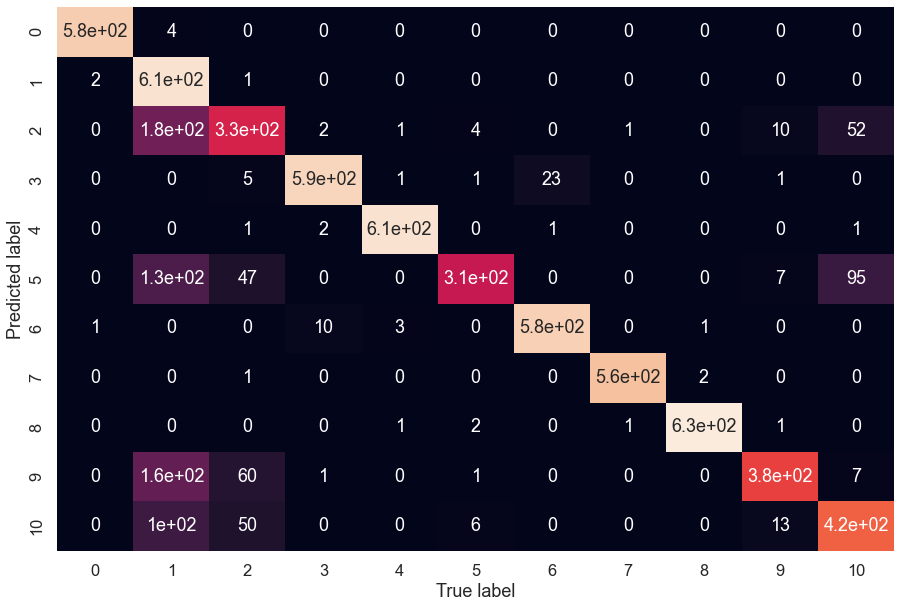

In [200]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_pred):
    """
    Plots a nice looking confusion matrix using Seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                    annot = True,
                    cbar=False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
    # For older versioin of jupiter noebook with distorted seabon
    # we can adjust by doing he following
     #bottom, top = ax.get_ylim()
     #ax.set_ylim(bottom + 0.5, top -0.5)
    
plot_conf_mat(y_test, y_pred)

In [201]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       583
           1       0.52      1.00      0.68       615
           2       0.67      0.57      0.61       583
           3       0.98      0.95      0.96       625
           4       0.99      0.99      0.99       618
           5       0.96      0.53      0.68       584
           6       0.96      0.97      0.97       598
           7       1.00      0.99      1.00       561
           8       1.00      0.99      0.99       634
           9       0.92      0.62      0.74       609
          10       0.73      0.71      0.72       590

    accuracy                           0.85      6600
   macro avg       0.88      0.85      0.85      6600
weighted avg       0.88      0.85      0.85      6600



In [202]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 3792.690190732246}

In [203]:
# Create a new classifier with best parameters
clf = LogisticRegression(C=4.281332398719396,
                         penalty="l2",
                        solver="liblinear")
clf

LogisticRegression(C=4.281332398719396, solver='liblinear')

In [204]:
%%time
# Cross-validated acuracy
cv_acc = cross_val_score(clf,X_transformed,y,cv=2,scoring="accuracy")
cv_acc = np.mean(cv_acc)
cv_acc

CPU times: total: 36.4 s
Wall time: 37.3 s


0.8505151515151514

In [205]:
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=2)

In [206]:
# %%time
# # Cross_validated precision
# cv_precision = cross_val_score(clf,X_transformed,y,cv=kf,scoring="precision")
# cv_precision = np.mean(cv_precision)
# cv_precision

In [207]:
# %%time
# # Cretate_validated recall
# cv_recall = cross_val_score(clf,X,y,cv=kf,scoring="recall")
# cv_recall = np.mean(cv_recall)
# cv_recall

In [208]:
# # Cross_validated f1-score
# cv_f1 = cross_val_score(clf,X,y,cv=kf,scoring="f1")
# cv_f1 = np.mean(cv_f1)
# cv_f1

In [209]:
# We remind ourselves of the best LogisticRegression parameter that was obtained
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 3792.690190732246}

In [210]:
# Fit an instance of the best LogisticRegression
clf = LogisticRegression(C=0.20433597178569418,
                        solver="liblinear")
clf.fit(X_train, y_train);

In [211]:
# Check coefficient
clf.coef_

array([[ 0.94826545, -0.3191533 , -0.1469367 , ..., -0.07358542,
        -0.06852602, -0.07882665],
       [-0.38247178, -2.5412227 , -0.28071808, ..., -1.20050543,
        -0.21706114, -0.31526578],
       [-0.24951135,  0.48144829, -1.52330898, ...,  0.804945  ,
        -0.15451708, -0.20800636],
       ...,
       [-0.07786986,  0.1910473 , -0.50495263, ..., -0.2489165 ,
         1.13123515,  1.02216262],
       [-0.24545468,  0.45016238, -0.7032555 , ..., -0.06782691,
        -0.38528935, -0.35796972],
       [-0.20939278,  0.09997497, -0.41311703, ..., -0.14600712,
        -0.11574691, -0.16269416]])

In [212]:
# Match coef's of features to columns
feature_dict = dict(zip(df_train.columns, list(clf.coef_[0])))
feature_dict

# The result tells us how much each column contributed to making our predictions
# for the target if someone had heart disease or not

{'lang_id': 0.9482654514007981, 'text': -0.3191532984933865}

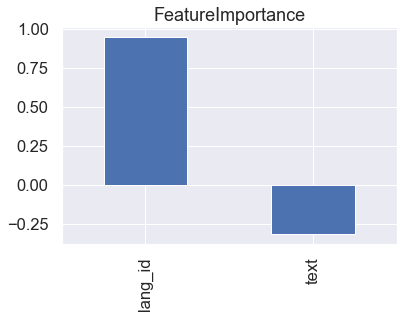

In [213]:
# Visualize feature importance
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="FeatureImportance", legend=False);

In [214]:
# Load test dataset
df_test = pd.read_csv("test_set.csv")

In [215]:
df_test.head(2)

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
